In [1]:
import pandas as pd
import numpy as np
from station import Station
import seaborn as sns
import matplotlib.pyplot as plt
import mpld3

%load_ext autoreload
%autoreload

In [2]:
# read in data files
ride_df = pd.read_csv('data/CTA_-_Ridership_-__L__Station_Entries_-_Daily_Totals.csv')
map_df = pd.read_csv('data/CTA_-_System_Information_-_List_of__L__Stops.csv')
station_map_names = {'Lake':'Lake/State', 'Jackson':'Jackson/State',
                     'Washington':'Washington/Dearborn', 'Morgan':'Morgan-Lake'}
map_df.replace({"STATION_NAME": station_map_names}, inplace=True)

In [3]:
station_summary = pd.read_csv('data/station_summary.csv')

### Determine best locations for pie shop

In [4]:
# calculate change from 2018 to predicted ridership in 2023
station_summary['pctchange_2018_2023'] = ((
    station_summary['2023_predicted_mean']/station_summary['2018_mean'])-1)*100
station_summary['rawchange_2018_2023'] = (
    station_summary['2023_predicted_mean']-station_summary['2018_mean'])

# find stations with mid-range daily ridership & high anticipated growth
m_high = station_summary.quantile(.80).loc['2018_mean']
m_low = station_summary.quantile(.25).loc['2018_mean']

mid_means_2018 = station_summary[(station_summary['2018_mean'] < m_high) & (
    station_summary['2018_mean'] > m_low)]

midmean_highgrowth = mid_means_2018.sort_values(by=['pctchange_2018_2023'], 
                                                ascending=False).reset_index().loc[0:5]
station_summary['midmean_highgrowth']=0
station_summary.loc[midmean_highgrowth['index'],'midmean_highgrowth']=1

In [17]:
# plot scatterplot: mean 2018 ridership vs. anticipated growth
# highlight stations selected for pie shop (mid-range mean high-growth stations)

df=station_summary[station_summary['2023_predicted_mean']>0]
x='2018_mean'
y='pctchange_2018_2023'
color = 'midmean_highgrowth'
fig, ax = plt.subplots(subplot_kw=dict(facecolor='#EEEEEE'))

scatter = ax.scatter(np.array(df[x], dtype=float),
                     np.array(df[y], dtype=float),
                     c=np.array(df[color], dtype=float),
                     alpha=0.9,
                     vmin=0,
                     vmax=6,
                     cmap='Set2')


ax.grid(color='white', linestyle='solid')

ax.set_title(x+' vs '+y, size=20)
ax.set_xlabel('2018 Mean Daily Rides', fontsize=16)
ax.set_ylabel('Projected % Growth 2018-2023', fontsize=16)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)

labels = df['station'].tolist()
tooltip = mpld3.plugins.PointLabelTooltip(scatter, labels=labels)
mpld3.plugins.connect(fig, tooltip)

mpld3.display()


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


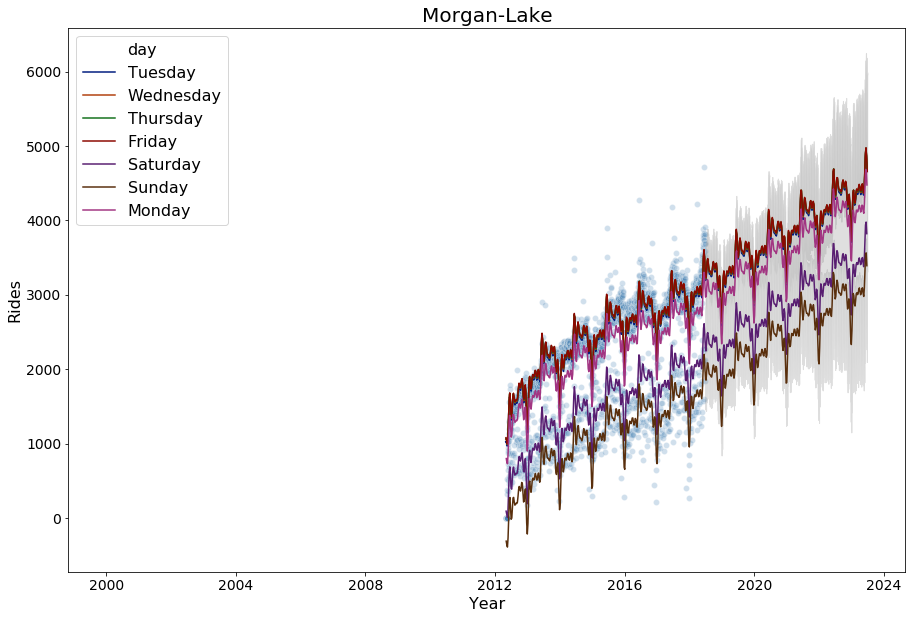

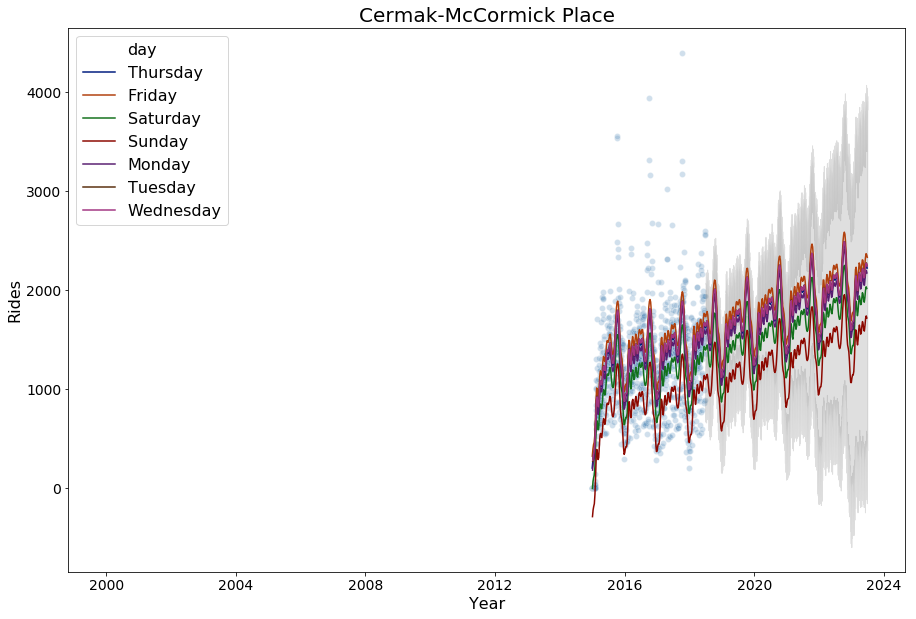

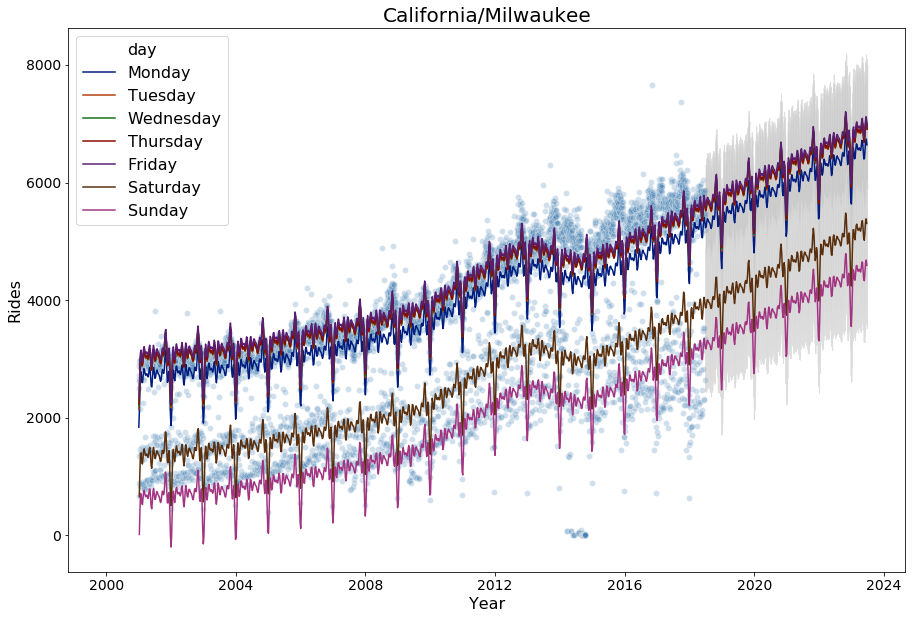

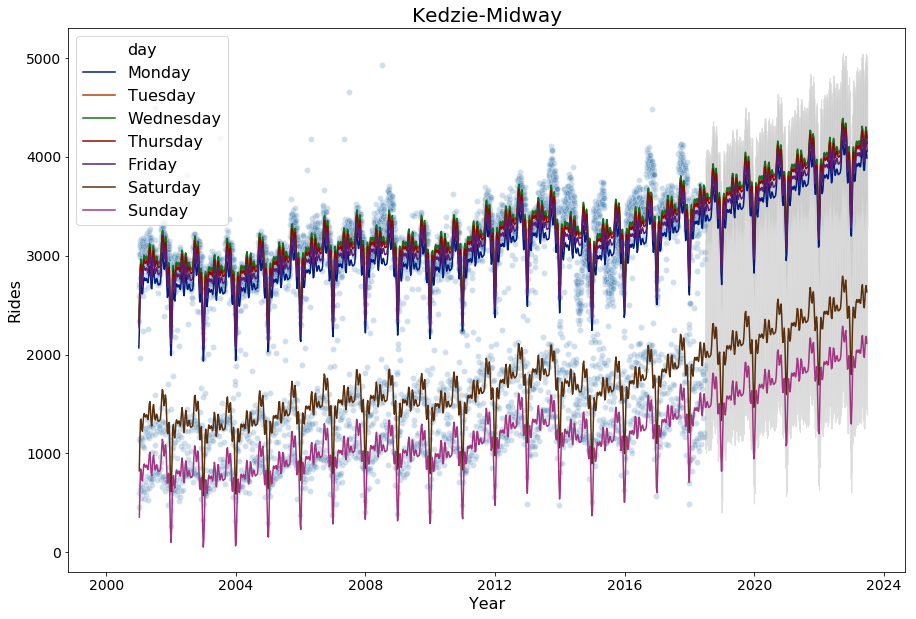

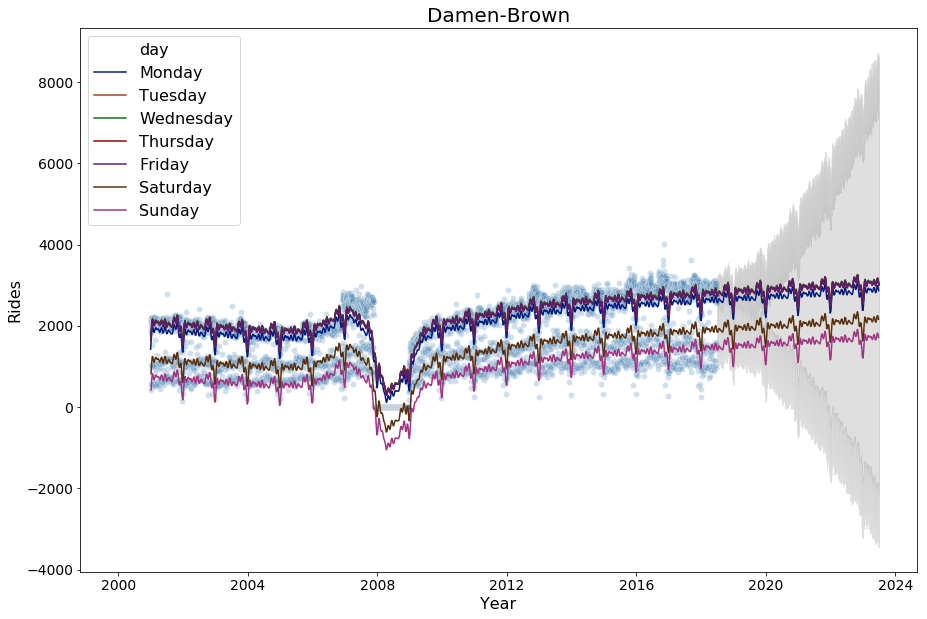

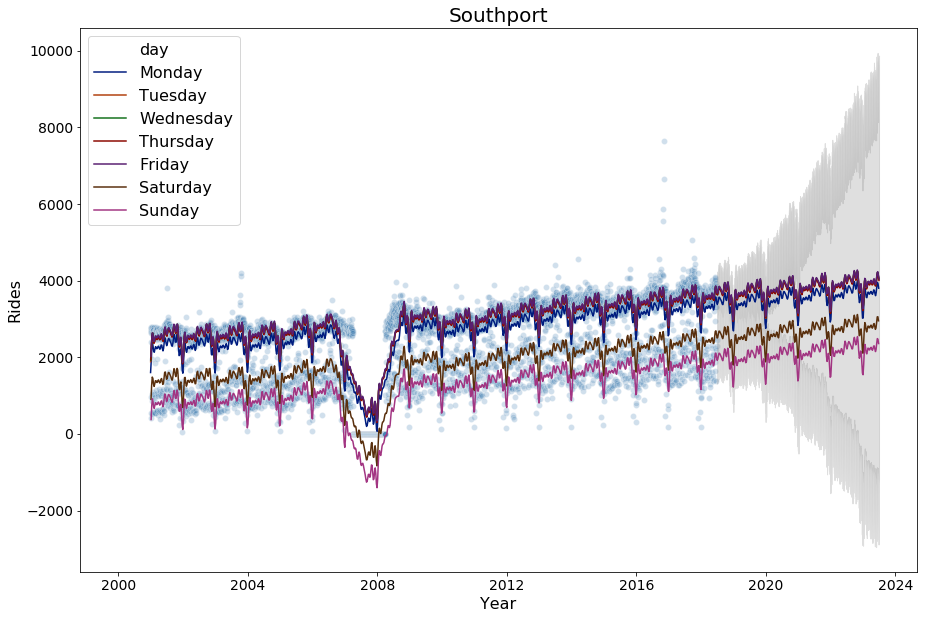

In [6]:
pie_stations = midmean_highgrowth.station.tolist()

# # rerun Station class on pie stations & make projection figs
for pie in pie_stations:
    stat = Station(pie, ride_df, map_df)
    stat.run_prophet()

    stat.preprocessed['day']=stat.preprocessed.index.weekday_name
    stat.forecast_all['day']=pd.DatetimeIndex(stat.forecast_all['ds']).weekday_name
    future = stat.forecast_all[stat.forecast_all['ds']>pd.to_datetime('06-30-2018')]
   
    fig, ax = plt.subplots(figsize=(15,10))
    sns.scatterplot(x='datetime', y='rides', 
                    data=stat.preprocessed.reset_index(), alpha=.25, color='steelblue', ax=ax)
    sns.lineplot(x='ds', y='yhat',hue='day', data=stat.forecast_all, palette='dark', ax=ax)
    ax.fill_between(np.array(future['ds']), np.array(future['yhat_lower']), 
                    np.array(future['yhat_upper']), color='grey', alpha=.25)
    plt.title(stat.name, fontsize=20)
    ax.xaxis.set_tick_params(labelsize=14)
    ax.yaxis.set_tick_params(labelsize=14)
    ax.set_xlabel('Year', fontsize=16)
    ax.set_ylabel('Rides', fontsize=16)
    plt.legend(loc='upper left', fontsize=16)
    fname = stat.name + '_growth.png'
    fname = fname.replace('/','_')
    plt.savefig('figs/' + fname)